In [1]:
# -------------- ZRE num exercise  ------------------------
# HonzaC, May 2023
# this is a demonstration, the level of programming is terrible ! 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.signal import spectrogram, lfilter, freqz, tf2zpk
from myfilter import myFilter                 # thanks Petr Palka ! 


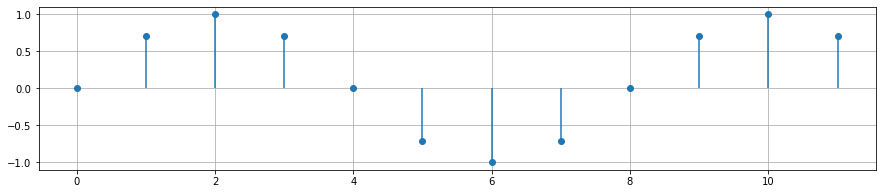

In [2]:
# 1 synthetic signal 
N = 12
n = np.arange(N)
f = 1/8
x = np.sin(2 * np.pi * f * n)
plt.figure(figsize=(15,3))
plt.stem(n,x,basefmt=" ", use_line_collection="true")
plt.gca().grid()


In [3]:
# 2 energy 
E = 1 / N * np.sum(np.square(x))
print (E)

0.5


In [4]:
# 3 zero crossing
now = x[1:]
past = x[0:-1]
print(np.sign(x))
Z = 1/2 * np.sum(np.abs(np.sign(now) - np.sign(past)))
print (Z)

[ 0.  1.  1.  1.  1. -1. -1. -1. -1.  1.  1.  1.]
2.5


In [5]:
# 4 correlation coeffs by hand and with a function
xorig = x; xpos = x; R0 = np.sum(xorig * xpos); print(R0)
xorig = x[0:-1]; xpos = x[1:]; R1 = np.sum(xorig * xpos); print(R1)
xorig = x[0:-2]; xpos = x[2:]; R2 = np.sum(xorig * xpos); print(R2)
# funkci ... 
R = np.correlate(x,x,"full")
print(R[11:14])


6.000000000000001
4.2426406871192865
0.5000000000000007
[6.         4.24264069 0.5       ]


In [6]:
# 4 direct solution of 2 equations with 2 unknowns 
R = [[R0, R1], [R1, R0]]
r = [-R1, -R2]
a = np.matmul (np.linalg.inv(R), r)
a1 = a[0]; a2 = a[1]; 
print(a)


[-1.29636243  0.83333333]


0.916666666666664
0.9166666666666679


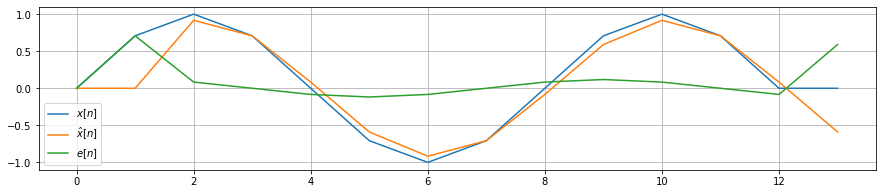

In [7]:
# 6 energy of prediction error. 
# by formula: 
Ee = R0 + R1 * a1 + R2 * a2
print (Ee)
# real prediction and determination of it's error 
xlong = np.pad(x, (0, 2), 'constant', constant_values=(0, 0))  # note that the signal must run for 2 more samples ! 
pred = lfilter(np.array([0,-a1,-a2]),1,xlong)
e = xlong - pred
plt.figure(figsize=(15,3))
nlong = np.arange(N+2)
plt.plot(nlong, xlong, label='$x[n]$')
plt.plot(nlong, pred, label=r'$\hat{x}[n]$')
plt.plot(nlong, e, label='$e[n]$')
plt.gca().grid()
plt.legend()
#print(xlong, pred, e)
Ee2 = np.sum(np.square(e))
print(Ee2)

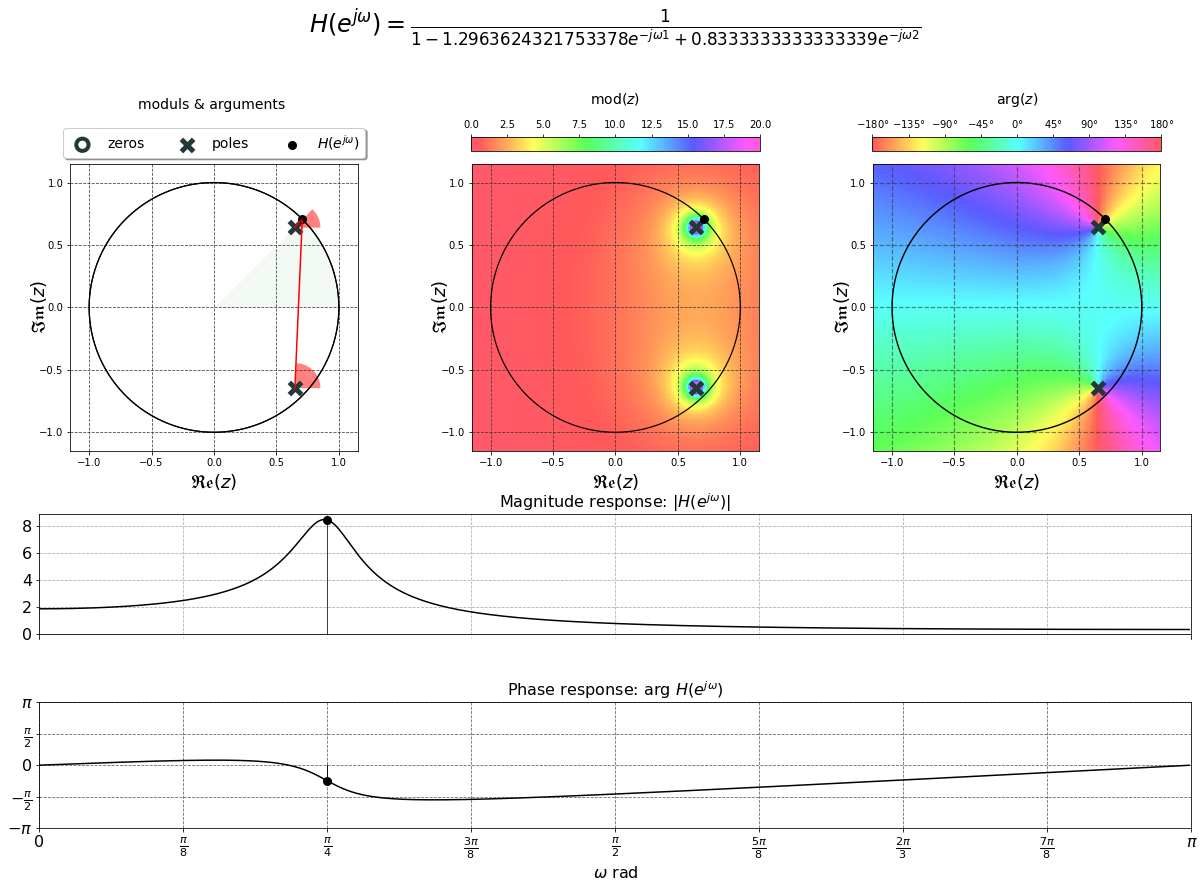

In [8]:
# 8 filter characteristics - thanks Peta Palka ! 
filter = myFilter([1], [1, a1, a2])
filter.demo(np.pi/4)

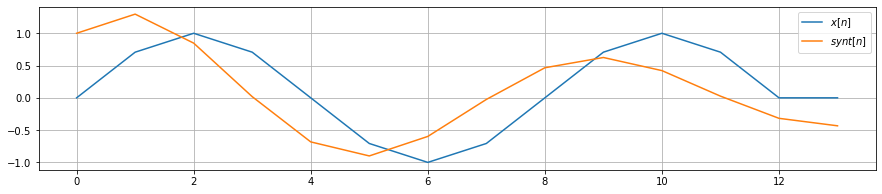

In [9]:
# synthesis by filtrer 1/A(z) - excitation just with a unit pulse ... 
e = np.zeros(nlong.shape)
e[0] = 1.0
synt = lfilter([1], [1,a1,a2],e)
#print(synt)
plt.figure(figsize=(15,3))
plt.plot(nlong, xlong, label='$x[n]$')
plt.plot(nlong, synt, label=r'$synt[n]$')
plt.gca().grid()
plt.legend()


In [10]:
# ------------------ HMM ---------------------------
O = [[0.5,1], [1.2,3], [1,2], [-0.5,-3], [-1,-5]]
A = [[0,1,0,0], [0,0.6,0.4,0], [0,0,0.7,0.3], [0,0,0,0]]
mu2 = [1,2]
mu3 = [-1,-2]
sigma2 = [2,2]
sigma3 = sigma2.copy()

# 2 Gaussian by hand  ... b2(o(1)), resp in Python   O[0]...
out = 1 / np.sqrt(2 * np.pi) / sigma2[0] * np.exp(- np.square(O[0][0] - mu2[0]) / 2 / np.square(sigma2[0])) * 1 / np.sqrt(2 * np.pi) / sigma2[1] * np.exp(- np.square(O[0][1] - mu2[1]) / 2 / np.square(sigma2[0]))
print(out)

0.034033109222882864


In [11]:
# now all emission likelihoods ... 
from scipy.stats import multivariate_normal
b2 = multivariate_normal.pdf(O, mean=mu2, cov=[[np.square(sigma2[0]), 0], [0, np.square(sigma2[1])]])
b3 = multivariate_normal.pdf(O, mean=mu3, cov=[[np.square(sigma3[0]), 0], [0, np.square(sigma3[1])]])
print(b2, b3)

[3.40331092e-02 3.49383071e-02 3.97887358e-02 1.31960685e-03
 5.27909160e-05] [0.00975065 0.00095464 0.00326606 0.03403311 0.01291751]


In [12]:
# likelihoody of individual state sequences - sorry, need to re-index for Python, and sorry for doing it this 
# terrible way by hand ;)  
# X1 = [1, 2, 3, 3, 3, 3, 4]
POX1M = A[0][1] * b2[0] * A[1][2] * b3[1] * A[2][2] * b3[2] * A[2][2] * b3[3] * A[2][2] * b3[4] * A[2][3]
# X2 = [1, 2, 2, 3, 3, 3, 4]
POX2M = A[0][1] * b2[0] * A[1][1] * b2[1] * A[1][2] * b3[2] * A[2][2] * b3[3] * A[2][2] * b3[4] * A[2][3]
# X3 = [1, 2, 2, 2, 3, 3, 4]
POX3M = A[0][1] * b2[0] * A[1][1] * b2[1] * A[1][1] * b2[2] * A[1][2] * b3[3] * A[2][2] * b3[4] * A[2][3]
# X4 = [1, 2, 2, 2, 2, 3, 4]
POX4M = A[0][1] * b2[0] * A[1][1] * b2[1] * A[1][1] * b2[2] * A[1][1] * b2[3] * A[1][2] * b3[4] * A[2][3]

print(POX1M, POX2M, POX3M, POX4M)

1.9200968169556076e-12 6.023327439557244e-11 6.289641441921054e-10 2.0903645524805025e-11


In [13]:
# 3 Baum Welch 
POM = POX1M + POX2M + POX3M + POX4M
print(POM)

7.120211609294385e-10


In [14]:
# 4 Viterbi 
POMstar = np.max([POX1M, POX2M, POX3M, POX4M])
print(POMstar)

6.289641441921054e-10


In [15]:
# 5 Token passing - preparation of logs 
Alog = np.log(A) # errors are OK, log of 0 is -inf ... 
print(Alog)
b2log = np.log(b2)
b3log = np.log(b3)
print(b2log, b3log)

[[       -inf  0.                -inf        -inf]
 [       -inf -0.51082562 -0.91629073        -inf]
 [       -inf        -inf -0.35667494 -1.2039728 ]
 [       -inf        -inf        -inf        -inf]]
[-3.38042143 -3.35417143 -3.22417143 -6.63042143 -9.84917143] [-4.63042143 -6.95417143 -5.72417143 -3.38042143 -4.34917143]


C:\Users\Honza\AppData\Local\Temp\ipykernel_9348\1070480867.py:2: RuntimeWarning: divide by zero encountered in log
  Alog = np.log(A) # errors are OK, log of 0 is -inf ...


In [16]:
# token passing - first index is state, 2nd index is time
print("--- time 1 - entering the model ---")
Psi21 = Alog[0][1] + b2log[0]
print (Psi21)

print("--- time 2 ---")
Psi22 = Psi21 + Alog[1][1] + b2log[1]
Psi32 = Psi21 + Alog[1][2] + b3log[1]
print (Psi22, Psi32)

print("--- time 3 ---")
Psi23 = Psi22 + Alog[1][1] + b2log[2]
Psi33 = np.max((Psi22 + Alog[1][2] + b3log[2], Psi32 + Alog[2][2] + b3log[2])) 
print (Psi23, Psi33)

print("--- time 4 ---")
Psi24 = Psi23 + Alog[1][1] + b2log[3]
Psi34 = np.max((Psi23 + Alog[1][2] + b3log[3], Psi33 + Alog[2][2] + b3log[3])) 
print (Psi24, Psi34)

print("--- time 5 ---")
Psi25 = Psi24 + Alog[1][1] + b2log[4]  # will be never used. 
Psi35 = np.max((Psi24 + Alog[1][2] + b3log[4], Psi34 + Alog[2][2] + b3log[4])) 
print (Psi25, Psi35)

print("--- time 6 - exiting the model ---")
Psi46 = Psi35 + Alog[2][3]
print (Psi46)

--- time 1 - entering the model ---
-3.380421427529236
--- time 2 ---
-7.245418478824463 -11.250883586932627
--- time 3 ---
-10.98041553011969 -13.885880638227853
--- time 4 ---
-18.121662581414917 -15.27712768952308
--- time 5 ---
-28.481659632710144 -19.982974060991047
--- time 6 - exiting the model ---
-21.186946865316983


In [17]:
# checking, that we got the Viterbi likelihood ... 
POMtoken_pass = np.exp(Psi46)
print(POMtoken_pass, POMstar)

6.289641441921067e-10 6.289641441921054e-10
